# Расчет длительности A/B-теста

Дата-инженеры выгрузили несколько файлов:

new_users_history.csv содержит историю привлечения новых пользователей;

funnel_history содержит данные о внутриигровых событиях, совершенных этими новыми пользователями.
    
Файл new_users_history.csv содержит колонки:

user_id - уникальный идентификатор пользователя;

dt - дата первого визита (регистрации) пользователя;

region - географический регион, из которого был совершен визит пользователя;

device - устройство, с которого был совершен визит пользователя;

acq_channel - рекламный канал из которого был совершен визит пользователя.
    
Файл funnel_history.csv содержит колонки:

user_id - уникальный идентификатор пользователя;

event_name - наименование аналитического события;

event_dt - дата и время отправки события в аналитическую систему;

region - географический регион, из которого был совершен визит пользователя;

Изучите исторические данные

Какова вероятность того, что пользователь успешно завершит обучение?

Рассчитайте необходимую длительность A/B-теста, считая, что:

Уровень значимости (alpha) и мощность (beta) равны 0.05 и 0.8;

Ожидается, что новый туториал повысит вероятность прохождения обучения на 3.8% (0.038).

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from scipy import stats
from datetime import datetime, timedelta
from statsmodels.stats.proportion import proportions_ztest
new_users = pd.read_csv('new_users_history.csv') 
funnel = pd.read_csv('funnel_history.csv')

new_users['dt'] = pd.to_datetime(new_users['dt'])
funnel['event_dt'] = pd.to_datetime(funnel['event_dt'])


In [4]:
new_users.info() 
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30560 entries, 0 to 30559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      30560 non-null  object        
 1   dt           30560 non-null  datetime64[ns]
 2   region       30560 non-null  object        
 3   device       30560 non-null  object        
 4   acq_channel  30560 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.2+ MB


,user_id,dt,region,device,acq_channel
0,-152afc2b288,2020-05-01,North America,iPhone,GameAds
1,f89bf8_-b02a,2020-05-01,Europe,iPhone,GameAds
2,949cd6682_a8,2020-05-01,Africa,iPhone,SenseAds
3,358ba3d0f-a2,2020-05-01,CN,iPhone,GameAds
4,f996bf887511,2020-05-01,CIS,iPhone,GameAds


In [5]:
funnel.info() 
funnel.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80254 entries, 0 to 80253
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     80254 non-null  object        
 1   event_name  80254 non-null  object        
 2   event_dt    80254 non-null  datetime64[ns]
 3   dt          80254 non-null  object        
 4   region      80254 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.1+ MB


,user_id,event_name,event_dt,dt,region
0,--014ca35_b7,login,2020-05-09 04:20:12,2020-05-09,North America
1,--014ca35_b7,tutorial_completed,2020-05-09 04:20:13,2020-05-09,North America
2,--014ca35_b7,tuturial_started,2020-05-09 04:20:11,2020-05-09,North America
3,--0424774bcb,login,2020-05-30 07:23:03,2020-05-30,CIS
4,--0424774bcb,tutorial_completed,2020-05-30 07:23:05,2020-05-30,CIS


In [6]:
report = funnel.groupby('event_name').agg({'user_id': ['count', 'nunique']}) 
report.columns = ['События', 'Уникальные пользователи']
report = report.sort_values(by = 'Уникальные пользователи', ascending = False)
report['%'] = report['Уникальные пользователи'] / report['Уникальные пользователи'].values[0]
report.style.format({'%': '{:.2%}'})


,События,Уникальные пользователи,%
event_name,,,
login,30560,30560,100.00%
tuturial_started,27408,27408,89.69%
tutorial_completed,22286,22286,72.93%


Расчет длительности теста

In [8]:
def get_sample_size(mean, std, relative_practical_significance, alpha, power):
    z = stats.norm.ppf(1 - alpha / 2) + abs(stats.norm.ppf(1 - power))  
    d = mean * relative_practical_significance
    return math.ceil(2 * ((std * z / d) ** 2))

На выходе этой функции мы получаем минимальное число наблюдений, которое нужно для обнаружения того, что mean изменилась на relative_practical_significance процентов.

Уровень значимости и можность мы задаем самостоятельно

In [10]:
alpha = 0.05
power = 0.8 
alpha, power


(0.05, 0.8)

In [11]:
import numpy as np 
import math
from scipy import stats
p = len(funnel.query('event_name == "tutorial_completed"')['user_id'].unique()) / len(funnel.query('event_name == "login"')['user_id'].unique())
tutorial_mean = p
tutorial_std = np.sqrt(p * (1 - p))

print('Средняя конверсия в прохождения туториала: {:.2%}, СКО конверсии: {:.2f}'.format (tutorial_mean, tutorial_std))


Средняя конверсия в прохождения туториала: 72.93%, СКО конверсии: 0.44


In [12]:
tutorial_sample_size = get_sample_size(tutorial_mean, tutorial_std, 0.038, alpha, power)
tutorial_sample_size

4037

In [13]:
mean_daily_users = new_users.groupby('dt').agg({'user_id': 'nunique'})['user_id'].mean ()
expected_test_participants_num = tutorial_sample_size * 2
print('Среднее число новых пользователей в день: {:.0f}, нужный размер выборки для двух групп: {}'.format(mean_daily_users, expected_test_participants_num))


Среднее число новых пользователей в день: 986, нужный размер выборки для двух групп: 8074


In [14]:
test_days_num = expected_test_participants_num / mean_daily_users
print('На проведение теста потребуется: {:.0f} дней'.format(test_days_num))


На проведение теста потребуется: 8 дней


Принимая в расчет сезонность, берем 14 дней.

# Оценка корректности проведения теста

In [17]:
test_participants = pd.read_csv('participants_run.csv') 
test_participants

,user_id,test_name,test_group
0,-5dabb4f564d,new_tutorial_test,A
1,9d335_2101b0,new_tutorial_test,A
2,29_1_-d06009,new_tutorial_test,A
3,4-11cdb_323_,new_tutorial_test,A
4,09a-1df--3-8,new_tutorial_test,A
...,...,...,...
2830,da548a441d78,new_tutorial_test,B
2831,4df97d74a826,new_tutorial_test,B
2832,49-8-d102058,new_tutorial_test,B
2833,8-512dcc03-6,new_tutorial_test,B


In [18]:
report = test_participants.groupby(['test_name', 'test_group']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
report['% участников'] = (report['Участники'] / report['Участники'].sum()).round(2) 
report


Участники  % участников
test_name         test_group                         
new_tutorial_test A                1368          0.48
                  B                1467          0.52

In [19]:
from statsmodels.stats.proportion import proportions_ztest
b_users = test_participants.query('test_group == "A"').shape[0] 
all_participants = test_participants.shape[0]

alpha = 0.05
pvalue = proportions_ztest(b_users, all_participants, value = 0.5)[1] 
print('p-value: {}'.format(pvalue))
if pvalue >= alpha:
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу B составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу B отличается от 50%')


p-value: 0.06281848165225283
Нулевая гипотеза не отвергается: вероятность попасть в группу B составляет 50%


# Анализ результатов теста

In [21]:
new_users = pd.read_csv('new_users_history.csv') 
funnel = pd.read_csv('funnel_test.csv')
test_participants = pd.read_csv('participants_run.csv')

new_users['dt'] = pd.to_datetime(new_users['dt'])
funnel['event_dt'] = pd.to_datetime(funnel['event_dt'])
test_participants.head(5)

,user_id,test_name,test_group
0,-5dabb4f564d,new_tutorial_test,A
1,9d335_2101b0,new_tutorial_test,A
2,29_1_-d06009,new_tutorial_test,A
3,4-11cdb_323_,new_tutorial_test,A
4,09a-1df--3-8,new_tutorial_test,A


In [22]:
print('Ожидаемое число участников теста: {}'.format(expected_test_participants_num)) 
print('Текущее число участников теста: {}'.format(test_participants['user_id'].nunique ()))

Ожидаемое число участников теста: 8074
Текущее число участников теста: 2835


In [23]:
test_participants.groupby(['test_name', 'test_group']).agg({'user_id': 'nunique'})

user_id
test_name         test_group         
new_tutorial_test A              1368
                  B              1467

In [24]:
alpha = 0.05

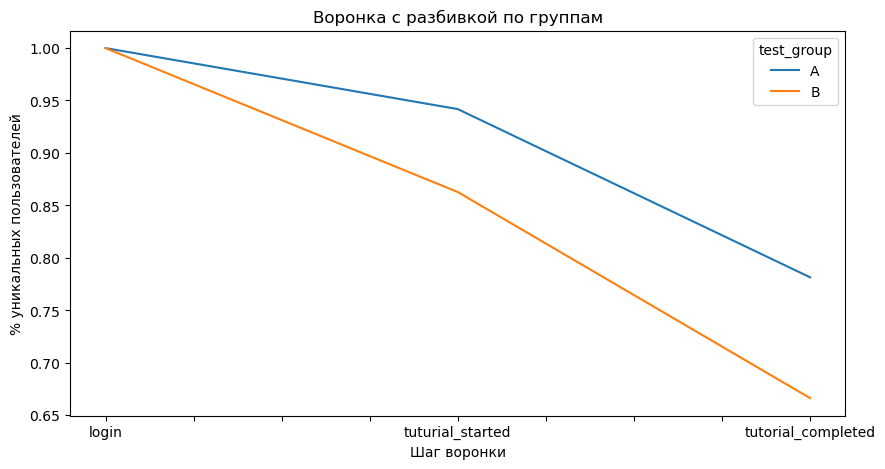

In [25]:
report = funnel.pivot_table(index = 'event_name', columns = 'test_group', values = 'user_id', aggfunc = 'nunique')
report = report.sort_values(by = 'A', ascending = False) 
report['A'] = report['A'] / report['A']['login']
report['B'] = report['B'] / report['B']['login'] 
report.plot(figsize = (10, 5))
plt.xlabel('Шаг воронки'), plt.ylabel('% уникальных пользователей'), plt.title('Воронка с разбивкой по группам');


In [26]:
report = funnel.pivot_table(index = 'test_group', columns = 'event_name', values = 'user_id', aggfunc = 'nunique')[['login', 'tuturial_started', 'tutorial_completed']]
report


event_name,login,tuturial_started,tutorial_completed
test_group,,,
A,4226,3980,3302
B,4325,3731,2881


In [27]:
count = list(report['tutorial_completed'].values) 
nobs = list(report['login'].values)
pvalue = proportions_ztest(count, nobs, value = 0)[1] 
print('p-value: {}'.format(pvalue))
if pvalue >= alpha:
    print('Нулевая гипотеза не отвергается: между группами A и B нет различий в % завершения туториала.')
else:
    print('Нулевая гипотеза отвергается: между группами A и B есть различие в % завершения туториала.')


p-value: 1.1152854995855214e-32
Нулевая гипотеза отвергается: между группами A и B есть различие в % завершения туториала.
